In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision

In [2]:
my_model = nn.Sequential(
    nn.Conv2d(in_channels=1,out_channels=16,kernel_size=2,stride=1,padding=0),
    nn.ReLU(),
    nn.Conv2d(in_channels=16,out_channels=32,kernel_size=2,stride=1,padding=0),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=21632,out_features=10)
)

In [3]:
summary(my_model,input_size=[(1,28,28)],batch_size=1,device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 16, 27, 27]              80
              ReLU-2            [1, 16, 27, 27]               0
            Conv2d-3            [1, 32, 26, 26]           2,080
              ReLU-4            [1, 32, 26, 26]               0
           Flatten-5                 [1, 21632]               0
            Linear-6                    [1, 10]         216,330
Total params: 218,490
Trainable params: 218,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 0.83
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


In [4]:
# 训练网络
# 定义一些东西
#优化器
optimizer = torch.optim.Adam(my_model.parameters(),lr=0.001)


In [5]:
# 训练数据集
mnist_dataset = torchvision.datasets.MNIST(root='./mnist',
                                           train=True,
                                           download=True,
                                          transform=torchvision.transforms.ToTensor())
# 验证数据集
mnist_val_dataset = torchvision.datasets.MNIST(root='./mnist',
                                           train=False,
                                           download=True,
                                          transform=torchvision.transforms.ToTensor())

In [6]:
# 数据导入器
# 训练数据导入器
mnist_data_loader = torch.utils.data.DataLoader(dataset=mnist_dataset,batch_size=32,shuffle=True)
# 验证数据导入器
mnist_val_loader = torch.utils.data.DataLoader(dataset=mnist_val_dataset,batch_size=32,shuffle=True)

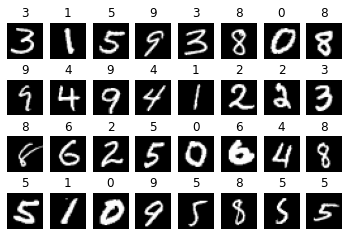

In [18]:
# 可视化导入器
import matplotlib.pyplot as plt
import numpy as np
data_iter = iter(mnist_data_loader)
for i in range(32):
    a,label = data_iter.__next__()
    show_image = np.transpose(a[0],(1,2,0))
    plt.subplot(4,8,i+1)
    plt.imshow(show_image,cmap='gray')
    plt.title(label[0].item())
    plt.axis('off')
plt.show()
    

In [7]:
def get_infinite_dataset(dataloader):
    while True:
        for item in dataloader:
            yield item

In [8]:
# 训练网络
data_loader = get_infinite_dataset(mnist_data_loader)
total_epoch = 1000
for i in range(total_epoch+1):
    # 训练步骤
    my_model.train()  #将模型调整为训练模式
    input,label = data_loader.__next__()
    output = my_model(input) # 计算模型输出
    optimizer.zero_grad() #清空优化器的历史梯度
    loss =  nn.CrossEntropyLoss()(output,label)
    loss.backward()   # 求损失函数的梯度并反向传播
    optimizer.step()  # 优化器优化一次模型参数
    if i % 100 == 0:
        print('epoch:',i,'loss:',loss.item())
    
    if i % 200 == 0:
        # 验证
        my_model.eval()
        total_correct = 0
        total_result = 0
        for item in mnist_val_loader:
            val_input,val_label = item
            output = my_model(val_input)  # 计算输出
            _,pred = torch.max(output,1)  # 把预测的标签最大值那一类取出
            # 统计计算了多少个样本
            total_result = total_result + val_label.size(0)
            # 统计预测正确了多少个样本
            total_correct = total_correct + ( pred == val_label ).sum()
            # 总的正确率
            total_accuracy = total_correct / total_result 
        # 打印信息
        print('epoch:',i,' ','total accuracy:',total_accuracy.item())

epoch: 0 loss: 2.2985548973083496
epoch: 0   total accuracy: 0.25999999046325684
epoch: 100 loss: 0.33553239703178406
epoch: 200 loss: 0.21489839255809784
epoch: 200   total accuracy: 0.9146000146865845
epoch: 300 loss: 0.1918065994977951
epoch: 400 loss: 0.09103279560804367
epoch: 400   total accuracy: 0.9492999911308289
epoch: 500 loss: 0.26550987362861633
epoch: 600 loss: 0.050790462642908096
epoch: 600   total accuracy: 0.9585999846458435
epoch: 700 loss: 0.13592396676540375
epoch: 800 loss: 0.1631193459033966
epoch: 800   total accuracy: 0.9650999903678894
epoch: 900 loss: 0.1037994921207428
epoch: 1000 loss: 0.15341167151927948
epoch: 1000   total accuracy: 0.9656000137329102


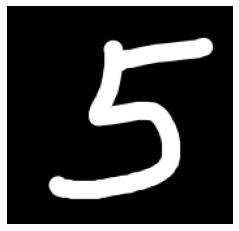

识别结果: 5


In [20]:
# 应用程序
from PIL import Image

# 输入图片
path = '1.jpg'
input_image = Image.open(path).convert('L')
plt.imshow(input_image,cmap='gray')
plt.axis('off')
plt.show()
# 把输入图片转化为Tensor
input_image = torchvision.transforms.ToTensor()(input_image)
input_image = torchvision.transforms.Resize((28,28))(input_image)

# 给 输入图片增加一个维度，这个维度表示其数量,1张
input_image = torch.unsqueeze(input_image,0)

# 输入图片到模型
output = my_model(input_image)
# 取出最大的输出，即预测结果
_,pred = torch.max(output,1)

print('识别结果:',pred.item())

